# Machine Learning Trading Bot

In [552]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [553]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [554]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


### Step 2: Generate trading signals using short- and long-window SMA values. 

In [555]:
# Set the short window and long window
short_window = 2
long_window = 60

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-03-13 15:00:00,23.79,0.000000,23.790,24.225000
2015-03-13 15:15:00,23.80,0.000420,23.795,24.222000
2015-03-13 15:45:00,23.84,0.001681,23.820,24.212333
2015-03-16 09:30:00,24.05,0.008809,23.945,24.205833
2015-03-16 10:15:00,24.04,-0.000416,24.045,24.198833


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.385,31.090167
2021-01-22 11:30:00,33.35,0.002405,33.310,31.141333
2021-01-22 13:45:00,33.42,0.002099,33.385,31.190333
2021-01-22 14:30:00,33.47,0.001496,33.445,31.245167
2021-01-22 15:45:00,33.44,-0.000896,33.455,31.298167


In [556]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-03-13 15:00:00,23.79,0.000000,23.790,24.225000,1.0
2015-03-13 15:15:00,23.80,0.000420,23.795,24.222000,1.0
2015-03-13 15:45:00,23.84,0.001681,23.820,24.212333,1.0
2015-03-16 09:30:00,24.05,0.008809,23.945,24.205833,1.0
2015-03-16 10:15:00,24.04,-0.000416,24.045,24.198833,-1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.385,31.090167,-1.0
2021-01-22 11:30:00,33.35,0.002405,33.310,31.141333,1.0
2021-01-22 13:45:00,33.42,0.002099,33.385,31.190333,1.0
2021-01-22 14:30:00,33.47,0.001496,33.445,31.245167,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.455,31.298167,-1.0


In [557]:
signals_df['Signal'].value_counts()

 1.0    2398
-1.0    1865
Name: Signal, dtype: int64

In [558]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-03-13 15:00:00,23.79,0.000000,23.790,24.225000,1.0,NaN
2015-03-13 15:15:00,23.80,0.000420,23.795,24.222000,1.0,0.000420
2015-03-13 15:45:00,23.84,0.001681,23.820,24.212333,1.0,0.001681
2015-03-16 09:30:00,24.05,0.008809,23.945,24.205833,1.0,0.008809
2015-03-16 10:15:00,24.04,-0.000416,24.045,24.198833,-1.0,-0.000416


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.385,31.090167,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.310,31.141333,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.385,31.190333,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.445,31.245167,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.455,31.298167,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

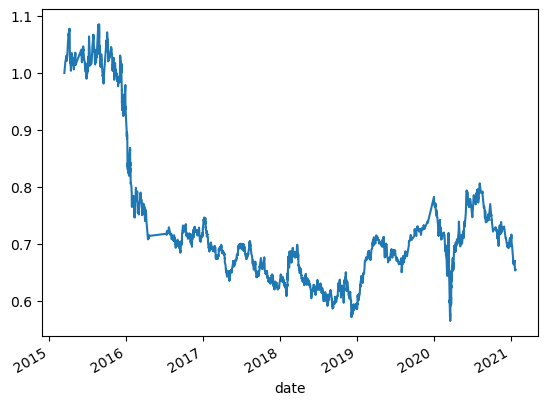

In [559]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [560]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-03-13 15:15:00,23.790,24.225000
2015-03-13 15:45:00,23.795,24.222000
2015-03-16 09:30:00,23.820,24.212333
2015-03-16 10:15:00,23.945,24.205833
2015-03-16 11:00:00,24.045,24.198833


In [561]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2398
-1.0    1865
Name: Signal, dtype: int64

In [562]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-03-13 15:15:00


In [563]:
# Select the ending period for the training data with an offset of 5 months
training_end = X.index.min() + DateOffset(months=5)

# Display the training end date
print(training_end)

2015-08-13 15:15:00


In [564]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-03-13 15:15:00,23.790,24.225000
2015-03-13 15:45:00,23.795,24.222000
2015-03-16 09:30:00,23.820,24.212333
2015-03-16 10:15:00,23.945,24.205833
2015-03-16 11:00:00,24.045,24.198833


In [565]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-03-13 15:15:00,23.790,24.225000
2015-03-13 15:45:00,23.795,24.222000
2015-03-16 09:30:00,23.820,24.212333
2015-03-16 10:15:00,23.945,24.205833
2015-03-16 11:00:00,24.045,24.198833


In [566]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [567]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(svm_pred)

[1. 1. 1. ... 1. 1. 1.]


### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [568]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.03      0.05      1764
         1.0       0.56      0.98      0.71      2251

    accuracy                           0.56      4015
   macro avg       0.54      0.50      0.38      4015
weighted avg       0.54      0.56      0.42      4015



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [569]:
# Create a new empty predictions DataFrame:
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df.loc[X_test.index, 'Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-08-14 11:30:00,1.0,-0.000448,-0.000448
2015-08-14 12:00:00,1.0,-0.002692,-0.002692
2015-08-14 13:00:00,1.0,0.000900,0.000900
2015-08-14 15:00:00,1.0,0.001348,0.001348
2015-08-14 15:15:00,1.0,0.000000,0.000000


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

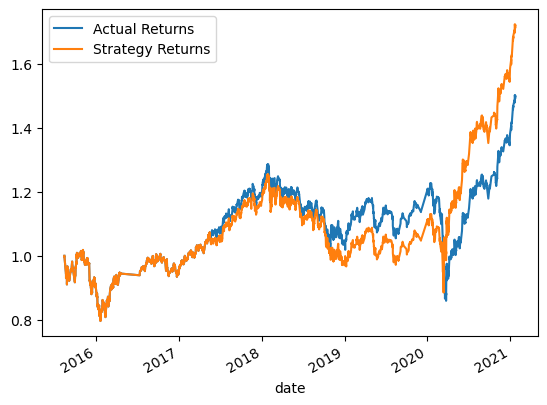

In [570]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot(ax=ax)

# Save the figure before showing it
plt.savefig('Resources/cumulative_returns_plot2.png')

# Display the plot
plt.show()

---

## Tune the Baseline Trading Algorithm

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`.

In [615]:
# Import the AdaBoostClassifier from sklearn
from sklearn.ensemble import AdaBoostClassifier

# Initiate the model instance
model = AdaBoostClassifier(n_estimators=100, random_state=0)

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [616]:
# Fit the model using the training data
model.fit(X_train, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = model.predict(X_test)

# Review the model's predicted values
print(pred)

[ 1.  1.  1. ... -1. -1. -1.]


### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [617]:
# Use a classification report to evaluate the model using the predictions and testing data
report = classification_report(y_test, pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

        -1.0       0.44      0.41      0.42      1764
         1.0       0.56      0.59      0.57      2251

    accuracy                           0.51      4015
   macro avg       0.50      0.50      0.50      4015
weighted avg       0.51      0.51      0.51      4015



In [618]:
# Create a predictions DataFrame
predictions = pd.DataFrame(index=X_test.index)

# Add the model predictions to the DataFrame
predictions['Predicted'] = model.predict(X_test)

# Add the actual returns to the DataFrame
predictions['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions['Strategy Returns'] = predictions['Actual Returns'] * predictions['Predicted']

# Review the DataFrame
predictions.head()

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-08-14 11:30:00,1.0,-0.000448,-0.000448
2015-08-14 12:00:00,1.0,-0.002692,-0.002692
2015-08-14 13:00:00,1.0,0.000900,0.000900
2015-08-14 15:00:00,1.0,0.001348,0.001348
2015-08-14 15:15:00,1.0,0.000000,0.000000


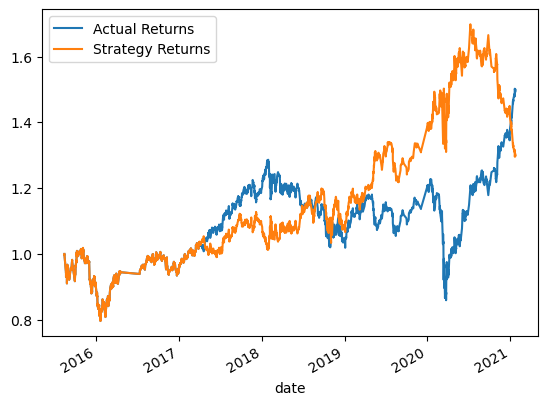

In [619]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the actual returns versus the strategy returns
(1 + predictions[['Actual Returns', 'Strategy Returns']]).cumprod().plot(ax=ax)

# Save the figure before showing it
plt.savefig('Resources/cumulative_returns_plot3.png')

# Display the plot
plt.show()